# EOF analysis with "eofs" python package

This code is an example of EOF analysis using the "eofs" python package : https://ajdawson.github.io/eofs/latest/userguide/index.html 

The data used here comes from a CNRM-CM6-1 CMIP6 simulation of monthly surface air temperature from 1850 to 2014 available in the GLOBC  team's common data on Scylla : /data/scratch/globc/dcom/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r10i1p1f2/Amon/tas/gr/latest/

A unique member of the model (r10i1p1f2) is used to compute the EOF analysis, we also show a projection of another member (r5i1p1f2) on the EOF basis, and examples of 3D field reconstructions.

Author/contact : Saloua Peatier (peatier@cerfacs.fr)

### Importe modules

In [1]:
# import the package "eofs"
from eofs.xarray import Eof

# import xarray, numpy and pandas 
import xarray as xr
import numpy as np
import pandas as pd
from pylab import *

# import plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

%matplotlib inline

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Get the data

In [133]:
## Load the data in a xarray.Dataset
path_CMIP6 = '/data/scratch/globc/dcom/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1'
path = path_CMIP6+'/historical/r10i1p1f2/Amon/tas/gr/latest/'
filename = 'tas_Amon_CNRM-CM6-1_historical_r10i1p1f2_gr_185001-201412.nc'
file = xr.open_mfdataset(path+filename,combine='by_coords')
X = file['tas']
#X

In [134]:
## Use pandas to transform the monthly data in anual data
X_df = X.to_dataframe(name='tas').reset_index().drop('height', axis=1)
X_df['time'] = X_df['time'].dt.year
X_df_yr = X_df.groupby(['time', 'lat', 'lon']).mean()
#X_df_yr

In [135]:
## Convert the panda dataframe in xarray, ready for EOF analysis
X_tmp = X_df_yr.to_xarray()
X = X_tmp['tas'].transpose("time", "lat", "lon")
#X

### EOF analysis

#### Spatial weightning
Before the EOF analysis, we usually want to weight spatially the data depending on the grid cell aire. 

The "eofs" package has a "weights" option that I do not recomand to use if we want to project new data on the EOF basis later on, as I noted that the "weighted" option of the "projectField" function usually ends in unexplained python error. 

I recomend weighting up the data before the EOF analysis and setting the "weights" option on False. Here, the data are weighted using $\sqrt{cos(lat)}$.

In [6]:
## Get spatial weights : 
lats = X['lat'].values
wgts = np.cos(np.deg2rad(lats))

## Here we add new axes to reproduce the data dimensions (time, lat, lon) :
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] 

In [136]:
# Take anomaly and weight the data  :
X_mean = X.mean(dim='time')
X_anom = X - X_mean
X_w = X_anom*W_eof_3D

#### Time to create the EOF solver

Few options have to be set :

<strong> "center" </strong> - <em> If True, the mean along the first axis of dataset (the time-mean) will be removed prior to analysis. If False, the mean along the first axis will not be removed. Defaults to True (mean is removed). The covariance interpretation relies on the input data being anomaly data with a time-mean of 0. Therefore this option should usually be set to True. Setting this option to True has the useful side effect of propagating missing values along the time dimension, ensuring that a solution can be found even if missing values occur in different locations at different times. </em>

<strong> "weights" </strong> - <em> An array of weights whose shape is compatible with those of the input array dataset. The weights can have the same shape as dataset or a shape compatible with an array broadcast (i.e., the shape of the weights can can match the rightmost parts of the shape of the input array dataset). If the input array dataset does not require weighting then the value None may be used. Defaults to None (no weighting). </em> <strong> Once again, I do not recomend using this option if we plan to project new data on the EOF basis using the function "projectField" later on. </strong>

In [8]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(X_w, center=False)

#### Retrieve the EOF spatial maps and PC time series
Several way of comptuting the EOF modes existn check : https://ajdawson.github.io/eofs/latest/api/eofs.xarray.html#eofs.xarray.Eof 

Here, we use : 

<strong> "eofsAsCovariance" </strong> - <em> Empirical orthogonal functions (EOFs) expressed as the covariance between the principal component time series (PCs) and the time series of the Eof input dataset at each grid point. </em>

Few options has to be set : 

<strong> "neofs" </strong> - <em> Number of EOFs to return. Defaults to all EOFs. If the number of EOFs requested is more than the number that are available, then all available EOFs will be returned. </em>

<strong> "pcscaling" </strong> - <em> Set the scaling of the PCs used to compute covariance. The following values are accepted:

<ul>
  <li>0 : Un-scaled PCs.</li>
  <li>1 : PCs are scaled to unit variance (divided by the square-root of their eigenvalue) (default).</li>
  <li>2 : PCs are multiplied by the square-root of their eigenvalue.
The default is to divide PCs by the square-root of their eigenvalue so that the PCs are scaled to unit variance (option 1).</li>
</ul>
</em>

<strong> "npcs" </strong> - <em> Number of PCs to retrieve. Defaults to all the PCs. If the number of requested PCs is more than the number that are available, then all available PCs will be returned. </em>

In [174]:
eof_w = solver.eofsAsCovariance(pcscaling=1)
pc = solver.pcs(pcscaling=1)

In [10]:
## Retrieve the variance explained by each EOF mode :
varFrac = solver.varianceFraction(neigs=5)

In [11]:
## The original X matrix was scaled with spatial weights before the analysis, 
## the eof matrix needs to be un-scaled to represent the real EOF modes :
eof = eof_w/W_eof_3D

## Plotting the first mode of variability

In [12]:
def eof_map_plot(data, eof_nb, title, units, label_min, label_max):
    # Plot the EOF map 

    var = data[eof_nb-1]
    xmin = np.min(var)
    xmax = np.max(var)
    lats = var['lat'][:]
    lons = var['lon'][:]
    var, lons = add_cyclic_point(var, coord=lons)

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = 16
    cmap = plt.get_cmap('coolwarm')  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=label_min,\
                   vmax=label_max, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='horizontal', drawedges=False, extend='both')

    cbar.set_label(units, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)
    
    #cbar.set_label(units, size = 12, style = 'italic')

    ax.coastlines()
    plt.clim(label_min, label_max)

    # Show la figure .................
    plt.show()

In [13]:
def pc_plot(data, pc_nb, ymin, ymax, title):
    
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Year', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Show la figure .................
    plt.show()

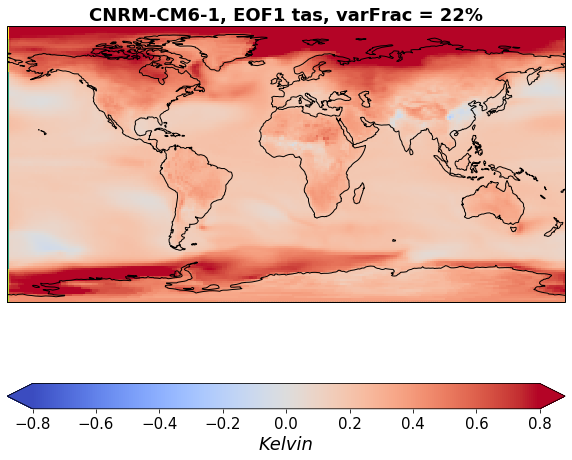

In [14]:
data = eof
eof_nb = 1
title = "CNRM-CM6-1, EOF1 tas, varFrac = "+str(int(varFrac[0].round(2)*100))+"%"
units = 'Kelvin'
label_min = -0.8
label_max = 0.8
eof_map_plot(data, eof_nb, title, units, label_min, label_max)

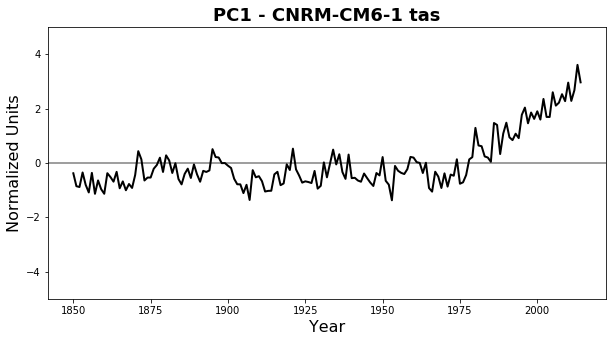

In [15]:
data = pc
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - CNRM-CM6-1 tas"
pc_plot(data, pc_nb, ymin, ymax, title)

# What else can we do ? 

**From this EOF solver, we can then project other data on the EOF basis with :** 

<strong> "projectField" </strong> - <em> Project a field onto the EOFs. Given a data set, projects it onto the EOFs to generate a corresponding set of pseudo-PCs. </em>

**Reconsctruct the original 3D data field with :** 

<strong> "reconstructedField" </strong> - <em> Reconstructed data field based on a subset of EOFs. Returns the reconstructed field in a DataArray. </em>

See the documentation for more : https://ajdawson.github.io/eofs/latest/api/eofs.xarray.html#eofs.xarray.Eof 

**Note : there is no *eofs* function to reconstruct projected fields, below is an example of how to do it with scalar products.**

In [57]:
def map_plot(data, title, units, label_min, label_max):
    # Plot the EOF map 

    var = data
    xmin = np.min(var)
    xmax = np.max(var)
    lats = var['lat'][:]
    lons = var['lon'][:]
    var, lons = add_cyclic_point(var, coord=lons)

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = 16
    cmap = plt.get_cmap('coolwarm')  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=label_min,\
                   vmax=label_max, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='horizontal', drawedges=False, extend='both')

    cbar.set_label(units, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)
    
    #cbar.set_label(units, size = 12, style = 'italic')

    ax.coastlines()
    plt.clim(label_min, label_max)

    # Show la figure .................
    plt.show()

## Reconstruct original data from PCs and EOFs

We reconstruct the data with the *eofs* function **reconstructedField** using all the EOFs (all the modes of variability), to validate that we are close to the original data.

In [275]:
## Reconstruction with the function from the package eofs
X_rec_w = solver.reconstructedField(len(X['time'])+10)

In [276]:
## Because the data were scaled and in anomalies, we need to add the mean 
## and divide by the weights to comare with the original data X
X_rec = (X_rec_w/W_eof_3D)+X_mean

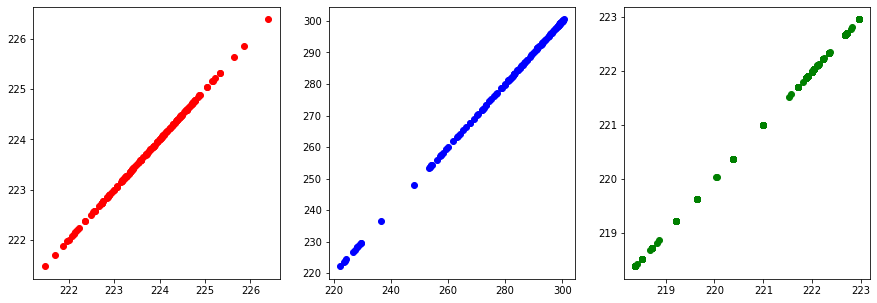

In [277]:
## X and X_rec should be equals (there are few differencies at 10^-14)
a = X.values
b = X_rec.values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(a[:,0,0], b[:,0,0], color='red', marker='o', linestyle=' ')
#ax1.set_xlim(222,225)
#ax1.set_ylim(222,225)
ax2.plot(a[0,:,0], b[0,:,0], color='blue', marker='o', linestyle=' ')
#ax2.set_xlim(222,300)
#ax2.set_ylim(222,300)
ax3.plot(a[0,0,:], b[0,0,:], color='green', marker='o', linestyle=' ')
#ax3.set_xlim(219,223)
#ax3.set_ylim(219,223)

## Project other data on EOF basis and get the pseudo-pcs
We can project another member of the CNRM-CM6 ensemble onto this EOF basis using the *eofs* function **projectField**

In [296]:
## Load the data in a xarray.Dataset
path_CMIP6 = '/data/scratch/globc/dcom/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1'
path = path_CMIP6+'/historical/r5i1p1f2/Amon/tas/gr/latest/'
filename = 'tas_Amon_CNRM-CM6-1_historical_r5i1p1f2_gr_185001-201412.nc'
file = xr.open_mfdataset(path+filename,combine='by_coords')
X_p = file['tas']

In [297]:
## Use pandas to transform the monthly data in anual data
X_df = X_p.to_dataframe(name='tas').reset_index().drop('height', axis=1)
X_df['time'] = X_df['time'].dt.year
X_df_yr = X_df.groupby(['time', 'lat', 'lon']).mean()

## Convert the panda dataframe in xarray, ready for EOF analysis
X_tmp = X_df_yr.to_xarray()
X_p = X_tmp['tas'].transpose("time", "lat", "lon")

In [298]:
# Remove previous mean and weight the data  :
X_anom = X_p - X_mean
X_w_p = X_anom*W_eof_3D

In [299]:
# Project data on the EOF basis
pc_p = solver.projectField(X_w_p, weighted=False, eofscaling=1)

In [162]:
def pc_plot_compare(data1, data2, pc_nb, ymin, ymax, title):
    
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    
    data1[:, pc].plot(color='black', linewidth=2, label='r10i1p1f2 (origin.)')
    ax1 = plt.gca()
    ax1.axhline(0, color='k', alpha=0.5)
    ax1.set_ylim(ymin, ymax)
    
    data2[:, pc].plot(color='red', linewidth=2, label='r5i1p1f2 (proj.)')
    ax2 = plt.gca()
    ax2.set_ylim(ymin, ymax)
    
    plt.xlabel('Year', size = 16)
    plt.ylabel('Normalized Units', size = 16)
    plt.title(title, fontsize=18, 
             fontweight = 'bold')
    
    ax1.legend(fontsize=12)
    ax2.legend(fontsize=12)

    # Show la figure .................
    plt.show()

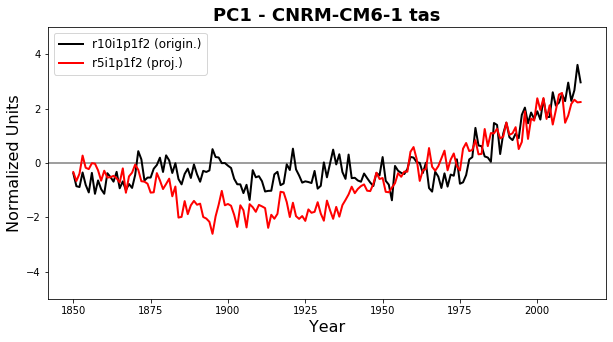

In [163]:
data1 = pc
data2 = pc_p
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - CNRM-CM6-1 tas"
pc_plot_compare(data1, data2, pc_nb, ymin, ymax, title)

## Reconstruct the projected data (from the pseudo-pcs)
There is no function in the package eofs to reconstruct the 3D field of a data that has been projected on the EOF basis. **"reconstructedField" only applies to the original data.**

Here, we reconstruct the data using a scalar product between EOFs and PCs. We create a function called **reconstruct_X** and validate it by reconstructing X and comparing the results with the original data. We then apply it to the projected member.

### Validation of the function "reconstruct_X"

In [269]:
## The function is a scalar product between EOFs and PCs 
def reconstruct_X(X, eof_w, pc) :
    
    ## Firstly, we have to combine all the EOFs in a same dataset 
    lat = X['lat']
    lon = X['lon']
    time = X['time']

    eofs_nb = np.arange(0,len(time), 1)
    eofs_xr = {}
    eofs_combined = {}

    ## --Combine the modes for reconstruction
    eofs_combined = xr.DataArray(eof_w, 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])
    
    ## Then, we compute the product for each year 
    X_rec = []
    for i in np.arange(0, len(pc['time']), 1) :
        x_rec_tmp = np.dot(eofs_combined.transpose(),pc[:,i])
        x_rec = xr.DataArray(x_rec_tmp, dims=["lon", "lat"]).transpose('lat', 'lon')
    
        x_rec['lat'] = eofs_combined['lat']
        x_rec['lon'] = eofs_combined['lon']
            
        X_rec.append(x_rec)
    
    ## Finally, we combine along a dimension 'time'
    
    X_rec_xr = xr.combine_nested(X_rec, concat_dim=['time'])
    
    return X_rec_xr

In [270]:
## Transpose pc to have same dimension order as eofs
pc = solver.pcs(pcscaling=1)
pc = pc.transpose('mode', 'time')

In [271]:
## Use function "reconstruct_X"
X_rec_w = reconstruct_X(X, eof_w, pc)

In [272]:
## Because the data were scaled and in anomalies, we need to add the mean 
## and divide by the weights to comare with the original data X
X_rec = (X_rec_w/W_eof_3D)+X_mean

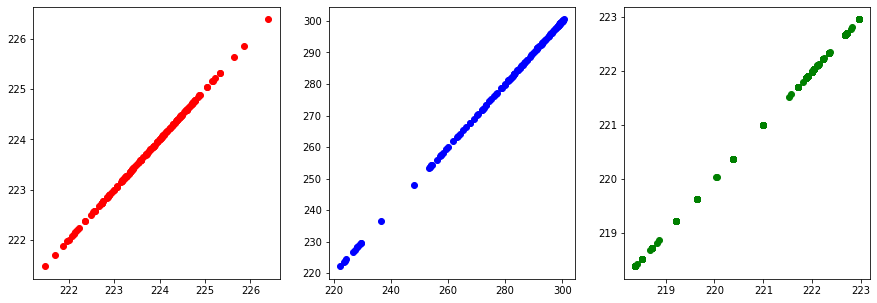

In [274]:
## X and X_rec should be equals 
a = X.values
b = X_rec.values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(a[:,0,0], b[:,0,0], color='red', marker='o', linestyle=' ')
#ax1.set_xlim(222,225)
#ax1.set_ylim(222,225)
ax2.plot(a[0,:,0], b[0,:,0], color='blue', marker='o', linestyle=' ')
#ax2.set_xlim(222,300)
#ax2.set_ylim(222,300)
ax3.plot(a[0,0,:], b[0,0,:], color='green', marker='o', linestyle=' ')
#ax3.set_xlim(219,223)
#ax3.set_ylim(219,223)

### Reconstruct projected data 
Here is an application of the function "reconstruct_X" from pseudo-pcs. 

Here the reconstruction is not exact (the reconstructed data are not equal to the original data). This is because we reconstruct a simulation that has not been used for the EOF analysis.

In [303]:
## Transpose pc_p to have same dimension order as eofs
pc_p = solver.projectField(X_w_p, weighted=False, eofscaling=1)
pc_p = pc_p.transpose('mode', 'time')

In [304]:
## Use function "reconstruct_X"
X_rec_w_p = reconstruct_X(X_p, eof_w, pc_p)

In [305]:
## Because the data were scaled and in anomalies, we need to add the mean 
## and divide by the weights to comare with the original data X
X_rec_p = (X_rec_w_p/W_eof_3D)+X_mean

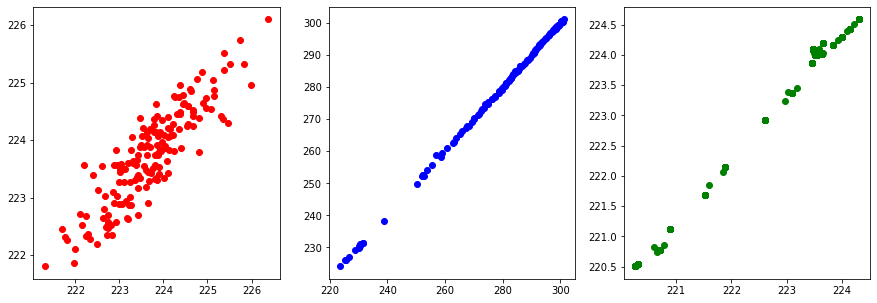

In [306]:
a = X_p.values
b = X_rec_p.values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(a[:,0,0], b[:,0,0], color='red', marker='o', linestyle=' ')
ax2.plot(a[0,:,0], b[0,:,0], color='blue', marker='o', linestyle=' ')
ax3.plot(a[0,0,:], b[0,0,:], color='green', marker='o', linestyle=' ')